In [54]:
import os
import mne
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mne.datasets import sample
from mne.viz import plot_compare_evokeds
from mne.time_frequency import tfr_morlet
from mne.channels import find_ch_adjacency
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.stats import spatio_temporal_cluster_test, combine_adjacency

In [20]:
event_map = {'Comment/101':101, 
             'Comment/109':109,
             'Comment/30':30,
             'Comment/40':40,
             'Comment/50':50,
             'Comment/51':51,
             'Comment/52':52,
             'Comment/60':60,
             'Comment/70':70,
             'Comment/80':80,
             'New Segment/':99999}

montage = mne.channels.read_custom_montage('./BC-MR3-64.bvef')

In [39]:
tmin=-0.2
tmax=0.5
event_id = {'Comment/60':60, 'Comment/70':70}

In [52]:
# Get active and sham groups from main csv
df = pd.read_csv('../joint/msc_collated_data_20230709.csv')
df = df[["participant_number", "session_type"]].drop_duplicates()

def remove_doubles(x):
    if(x.nunique()==2):
        return 'sham group'
    elif(x.nunique()==1):
        return 'active group'

df["condition"] = df.groupby('participant_number')['session_type'].transform(remove_doubles)
df = df.drop(columns="session_type").drop_duplicates()
df['participant_number'] = df['participant_number'].replace(r'sub-', r'm_', regex=True)

active_ids = df[df.condition=='active group'].participant_number.to_list()
sham_ids = df[df.condition=='sham group'].participant_number.to_list()
# active_ids, sham_ids

In [55]:
# Get list of filenames for each group:
cleaned_dir = './ica_notebooks/cleaned'

active_eeg_files = []
sham_eeg_files = []

for root, dirs, files in os.walk(cleaned_dir):
    for file in files:
        # Actives
        if file.endswith('.vhdr') and any(id in file for id in active_ids):
            active_eeg_files.append(os.path.join(root, file))
        # Sham 
        elif file.endswith('.vhdr') and any(id in file for id in sham_ids):
            sham_eeg_files.append(os.path.join(root, file))

active2bs = []
active2as = []
active1as = []
active1bs = []

sham2bs = []
sham2as = []
sham1as = []
sham1bs = []

# Just look at Posner 2b
for x in active_eeg_files:
    if 'pos2b' in x:
        active2bs.append(x)
    if 'pos1a' in x:
        active1as.append(x)
    if 'pos1b' in x:
        active1bs.append(x)
    if 'pos2a' in x:
        active2as.append(x)
for x in sham_eeg_files:
    if 'pos2b' in x:
        sham2bs.append(x)
    if 'pos1a' in x:
        sham1as.append(x)
    if 'pos1b' in x:
        sham1bs.append(x)
    if 'pos2a' in x:
        sham2as.append(x)

active2bs, sham2bs

(['./ica_notebooks/cleaned/m_09_02/m_09_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_19_02/m_19_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_07_02/m_07_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_03_02/m_03_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_16_02/m_16_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_15_02/m_15_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_20_02/m_20_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_14_02/m_14_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_00_02/m_00_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_10_02/m_10_02_pos2b.vhdr'],
 ['./ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_18_02/m_18_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_17_02/m_17_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_13_02/m_13_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_02_02/m_02_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_12_02/m_12_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_01_02/m_01_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_05_02/m_05_02_pos2

In [136]:
# Define the frequency bands of interest
freqs = np.logspace(*np.log10([3, 30]), num=8)  # alpha to gamma frequencies
# freqs = np.arange(7, 20, 2)
n_cycles = freqs / 2.  # different number of cycle per frequency

def process_group(file_names, focal_event):
    epochs_list = list()
    powers = list()
    for file in file_names:
        # Load raw
        raw = mne.io.read_raw(file, preload=True)
        print('dropping channel');raw.drop_channels('ECG')
        # Filter ?
        filt_raw = raw.copy().filter(l_freq=1.0, h_freq=30)
        # Events
        events, event_id = mne.events_from_annotations(raw, event_map) # get events
        # Re-reference
        # avg_ref = raw.copy().set_eeg_reference(ref_channels="average")
        # Get epochs
        reject_crit = dict(
            eeg=1000e-6,
        )

        epochs = mne.Epochs(raw=raw, 
                            events=events, 
                            event_id=focal_event, 
                            detrend=1, 
                            tmin=-1, 
                            tmax=3, 
                            baseline=(None, 0),
                            preload=True,
                            reject=reject_crit,
                            # picks=picks,
                            event_repeated='drop')

        epochs.set_montage(montage)
        # test_epochs.plot(events=test_events)
        power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=1) # get tfr_morlet
        power.info.set_montage(montage) # set_montage
        powers.append(power)
        epochs_list.append(epochs)
        # epochs.plot_drop_log()
    return powers, epochs_list

In [134]:
sham_2b_pow, sham_2b_epochs = process_group(sham2bs, event_id)

Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
54 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 54 events and 4001 original time points ...
    Rejecting  epoch based on EEG : ['P7', 'TP9', 'TP10', 'P5', 'FT7', 'TP7', 'TP8']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['O1', 'O2', 'P7', 'Oz', 'TP9', 'TP10', 'FT7', 'TP8']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['O2', 'Oz', 'TP9', 'TP10', 'FT7', 'TP8']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecti

[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


    Rejecting  epoch based on EEG : ['TP9', 'TP10', 'FT7']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['FC5', 'TP9', 'FC3', 'F5', 'C5', 'FT7', 'FT9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
37 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
48 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 4001 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'C4', 'F7', 'F8', 'T7', 'T8', 'FC5', 'FC6', 'CP5', 'CP6', 'TP10', 'FC3', 'FC4', 'F5', 'F6', 'C5', 'C6', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'FT9', 'FT10']
    Rejecting  epoch based on EEG : ['C4', 'F7', 'F8', 'T7', 'T8', 'FC5', 'FC6', 'CP5', 'CP6', 'FC4', 'F5', 'F6', 'C5', 'C6', 'FT7', 'FT8', 'FT9', 'FT10']
    Rejecting  epoch based on EEG : ['F8', 'T7', 'T8', 'FC5', 'FC6', 'CP6', 'FC4', 'C5', 'C6', 'FT7', 'FT8', 'FT9', 'FT10']
    Rejecting  epoch based on EEG : ['F8', 'T7', 'T8', 'FC6', 'FC4', 'C6', 'FT7', 'FT8', 'FT10']

[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


    Rejecting  epoch based on EEG : ['T7', 'T8', 'FC6', 'CP5', 'FC4', 'FT7', 'FT8', 'FT9']
    Rejecting  epoch based on EEG : ['F8', 'T7', 'T8', 'FC5', 'FC6', 'FC4', 'C5', 'C6', 'FT7', 'FT8']
    Rejecting  epoch based on EEG : ['F8', 'T7', 'T8', 'FC5', 'FC6', 'FC4', 'C6', 'FT7', 'FT8']
    Rejecting  epoch based on EEG : ['FC6', 'FT8']
    Rejecting  epoch based on EEG : ['F8', 'T7', 'T8', 'FC5', 'FC6', 'CP5', 'TP9', 'FC4', 'C6', 'FT7', 'FT8', 'FT10']
    Rejecting  epoch based on EEG : ['F8', 'T7', 'T8', 'FC6', 'FC4', 'C6', 'FT7', 'FT8']
    Rejecting  epoch based on EEG : ['T7', 'T8', 'FC6', 'TP9', 'FC4', 'C6', 'FT8']
    Rejecting  epoch based on EEG : ['F8', 'T7', 'T8', 'FC5', 'FC6', 'FC4', 'C5', 'C6', 'FT7', 'FT8', 'TP7', 'FT9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Oz', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'T

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
55 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 55 events and 4001 original time points ...
    Rejecting  epoch based on EEG : ['F4', 'C4', 'P4', 'O2', 'T8', 'Pz', 'CP2', 'TP9', 'TP10', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'C5', 'C6', 'P5', 'P6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG 

[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


    Rejecting  epoch based on EEG : ['F8', 'T8', 'FC5', 'FC6', 'TP9', 'F6', 'C6', 'FT8', 'TP8', 'FT10']
    Rejecting  epoch based on EEG : ['F7', 'T7', 'T8', 'P8', 'FC5', 'TP9', 'FC3', 'FT7']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['FC5', 'FC6', 'TP9', 'FT7', 'FT8']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9', 'F5']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['F8', 'T7', 'T8', 'FC5', 'FC6', 'CP5', 'TP9', 'F6', 'C5', 'C6', 'FT7', 'FT8', 'TP7', 'TP8', 'FT9', 'FT10']
    Rejecting  epoch based on EEG : ['O1', 'F8', 'T8', 'FC6', 'TP9', 'TP10', 'F6', 'FT8', 'TP7', 'PO7

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
70 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 70 events and 4001 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'T7', 'T8', 'P7', 'P8', 'CP5', 'TP9', 'TP10', 'PO3', 'P5', 'TP7', 'TP8']
    Rejecting  epoch based on EEG : ['T8', 'P7', 'TP10', 'TP7']
    Rejecting  epoch based on EEG : ['T8', 'TP10', 'TP7']
    Rejecting  epoch based on EEG : ['T8', 'TP7']
    Rejecting  epoch based on EEG : ['T8', 'TP7']
    Rejecting  epoch based on EEG : ['T8', 'PO3']
    Rejecting  epoch based on EEG : ['Fp1', 'FC5']
    Rejecting  epoch based on EEG : ['Fp1']


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


    Rejecting  epoch based on EEG : ['Fp1', 'F8', 'T7', 'T8', 'FC5', 'FC6', 'TP9', 'C5', 'FT7', 'FT8', 'FT9', 'FT10']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'PO3']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'C3', 'F7', 'F8', 'T7', 'T8', 'P7', 'FC5', 'FC6', 'CP5', 'TP9', 'TP10', 'FC3', 'CP3', 'F5', 'F6', 'C5', 'C6', 'P5', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'FT9', 'FT10']
    Rejecting  epoch based on EEG : ['O1', 'PO3']
    Rejecting  epoch based on EEG : ['TP9']
13 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
68 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 68 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
75 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 75 events and 4001 original time points ...
    Rejecting  epoch based on EEG : ['FT9']


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


1 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
63 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 63 events and 4001 original time points ...
    Rejecting  epoch based on EEG : ['C3']


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz']
2 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
57 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 57 events and 4001 original time points ...
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FC3', 'FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
20 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
79 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 79 events and 4001 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'P3', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Oz', 'FC5', 'FC6', 'CP5', 'TP9', 'TP10', 'POz', 'AF4', 'FC3', 'FC4', 'CP3', 'PO3', 'F5', 'F6', 'C5', 'C6', 'P5', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz']
    Rejecting  epoch based on EEG : ['F8', 'T8', 'P7', 'FC6', 'TP10', 'F6', 'C6', 'AF7', 'AF8', 'FT8', 'FT9', 'FT10']


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


    Rejecting  epoch based on EEG : ['CPz']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['F8', 'FC6', 'F6', 'AF8']
5 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2627901211.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


In [119]:
active_2b_pow, active_2b_epochs = process_group(active2bs, event_id)

Extracting parameters from ./ica_notebooks/cleaned/m_09_02/m_09_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 516619  =      0.000 ...   516.619 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
55 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 55 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:35: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_19_02/m_19_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 686119  =      0.000 ...   686.119 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:38: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
64 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 64 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:35: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_07_02/m_07_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 678635  =      0.000 ...   678.635 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:38: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
62 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 62 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:35: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_03_02/m_03_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 696262  =      0.000 ...   696.262 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:38: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
62 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 62 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:35: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_16_02/m_16_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 700376  =      0.000 ...   700.376 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:38: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
73 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 73 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:35: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_15_02/m_15_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 687590  =      0.000 ...   687.590 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:38: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
65 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 65 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:35: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_20_02/m_20_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 507628  =      0.000 ...   507.628 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:38: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
53 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:35: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_14_02/m_14_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667933  =      0.000 ...   667.933 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:38: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
68 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 68 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:35: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_00_02/m_00_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 679689  =      0.000 ...   679.689 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:38: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
71 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 71 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:35: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_10_02/m_10_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668899  =      0.000 ...   668.899 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:38: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
64 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 64 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:35: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/2863970562.py:38: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


# TEST

In [128]:
raw_ = mne.io.read_raw('./ica_notebooks/cleaned/m_00_01/m_00_01_pos1a.vhdr', preload=True)
# raw.filter(1, 30)
# events = mne.events_from_annotations(raw_, event_map)

picks=mne.pick_types(raw_.info, eeg=True, eog=True)

epochs = mne.concatenate_epochs(active_2b_epochs)

epochs.set_montage(montage)
# epochs.drop_channels('ECG')
epochs.equalize_event_counts(event_id)
X = [epochs[event_name].get_data() for event_name in event_id]
X = [np.transpose(x, (0, 2, 1)) for x in X]

Extracting parameters from ./ica_notebooks/cleaned/m_00_01/m_00_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 685731  =      0.000 ...   685.731 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/1504646317.py:7: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(active_2b_epochs)


Not setting metadata
637 matching events found
Applying baseline correction (mode: mean)
Dropped 7 epochs: 26, 63, 64, 69, 76, 77, 78


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/1504646317.py:9: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 63
<class 'scipy.sparse._csr.csr_matrix'>


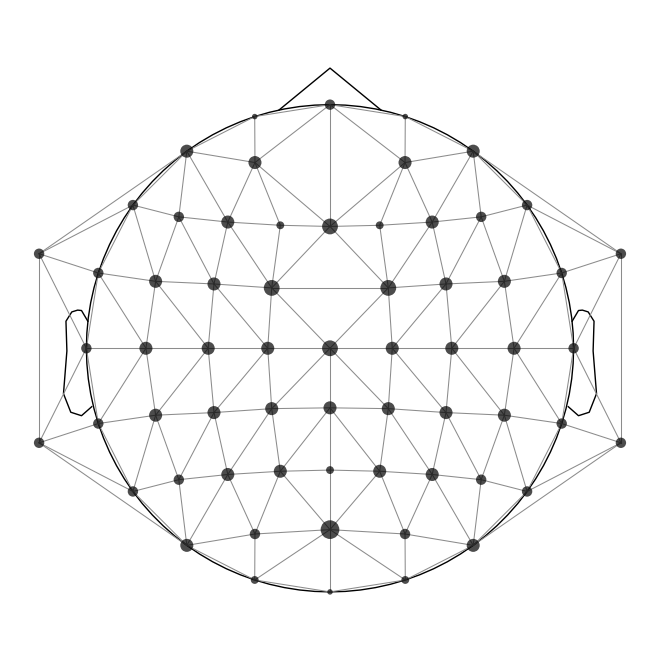

In [129]:
adjacency, ch_names = find_ch_adjacency(epochs.info, ch_type="eeg")

print(type(adjacency))  # it's a sparse matrix!

mne.viz.plot_ch_adjacency(epochs.info, adjacency, ch_names)

plt.show()

In [130]:
# We are running an F test, so we look at the upper tail
# see also: https://stats.stackexchange.com/a/73993
tail = 1

# We want to set a critical test statistic (here: F), to determine when
# clusters are being formed. Using Scipy's percent point function of the F
# distribution, we can conveniently select a threshold that corresponds to
# some alpha level that we arbitrarily pick.
alpha_cluster_forming = 0.01

# For an F test we need the degrees of freedom for the numerator
# (number of conditions - 1) and the denominator (number of observations
# - number of conditions):
n_conditions = len(event_id); print(n_conditions)
n_observations = len(X[0]); print(n_observations)
dfn = n_conditions - 1
dfd = n_observations - n_conditions

# Note: we calculate 1 - alpha_cluster_forming to get the critical value
# on the right tail
f_thresh = scipy.stats.f.ppf(1 - alpha_cluster_forming, dfn=dfn, dfd=dfd)

# run the cluster based permutation analysis
cluster_stats = spatio_temporal_cluster_test(
    X,
    n_permutations=1000,
    threshold=f_thresh,
    tail=tail,
    n_jobs=None,
    buffer_size=None,
    adjacency=adjacency,
)
F_obs, clusters, p_values, _ = cluster_stats

2
315
stat_fun(H1): min=0.000000 max=16.139736
Running initial clustering …
Found 471 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [116]:
# We subselect clusters that we consider significant at an arbitrarily
# picked alpha level: "p_accept".
# NOTE: remember the caveats with respect to "significant" clusters that
# we mentioned in the introduction of this tutorial!
p_accept = 0.02
good_cluster_inds = np.where(p_values < p_accept)[0]

print('good cluster inds:', (p_values))

# configure variables for visualization
colors = {"Comment/60": "crimson", "Comment/70": "steelblue"}
linestyles = {"Comment/60": "-", "Comment/70": "--"}

# organize data for plotting
evokeds = {cond: epochs[cond].average() for cond in event_id}

# loop over clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # get topography for F stat
    f_map = F_obs[time_inds, ...].mean(axis=0)

    # get signals at the sensors contributing to the cluster
    sig_times = epochs.times[time_inds]

    # create spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # plot average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(f_map[:, np.newaxis], epochs.info, tmin=0)
    f_evoked.plot_topomap(
        times=0,
        mask=mask,
        axes=ax_topo,
        cmap="Reds",
        vlim=(np.min, np.max),
        show=False,
        colorbar=False,
        mask_params=dict(markersize=10),
    )
    image = ax_topo.images[0]

    # remove the title that would otherwise say "0.000 s"
    ax_topo.set_title("")

    # create additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        "Averaged F-map ({:0.3f} - {:0.3f} s)".format(*sig_times[[0, -1]])
    )

    # add new axis for time courses and plot time courses
    ax_signals = divider.append_axes("right", size="300%", pad=1.2)
    title = "Cluster #{0}, {1} sensor".format(i_clu + 1, len(ch_inds))
    if len(ch_inds) > 1:
        title += "s (mean)"
    plot_compare_evokeds(
        evokeds,
        title=title,
        picks=ch_inds,
        axes=ax_signals,
        colors=colors,
        linestyles=linestyles,
        show=False,
        split_legend=True,
        truncate_yaxis="auto",
    )

    # plot temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx(
        (ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.3
    )

    # clean up viz
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=0.05)
    plt.show()

good cluster inds: [1. 1. 1. ... 1. 1. 1.]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


# ON neurofeedback data?